# Imports

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error

# Data preparation

In [43]:
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

In [45]:
df = pd.read_csv('data/train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('data/test.csv', parse_dates=['datetime'],index_col=0)

In [46]:
# parse data
def add_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

In [47]:
add_features(df)
add_features(df_test)

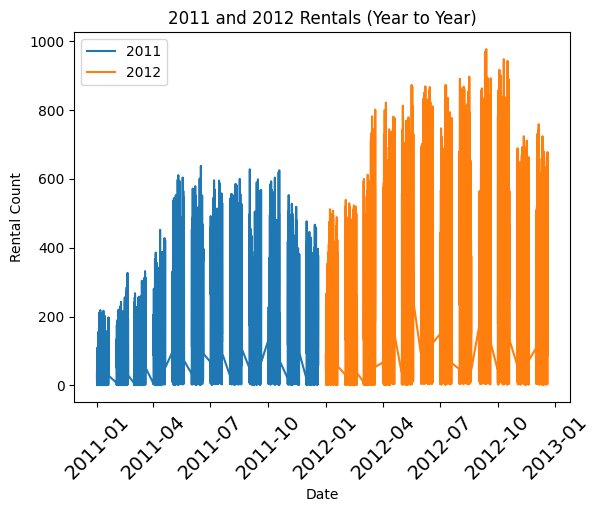

In [48]:
plt.plot(df.loc['2011']['count'],label='2011')
plt.plot(df.loc['2012']['count'],label='2012')
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Rental Count')
plt.title('2011 and 2012 Rentals (Year to Year)')
plt.legend()
plt.show()

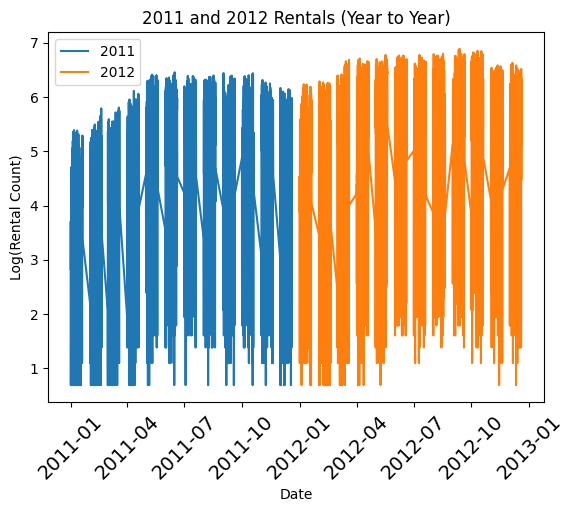

In [49]:
plt.plot(df.loc['2011']['count'].map(np.log1p),label='2011')
plt.plot(df.loc['2012']['count'].map(np.log1p),label='2012')
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Log(Rental Count)')
plt.title('2011 and 2012 Rentals (Year to Year)')
plt.legend()
plt.show()

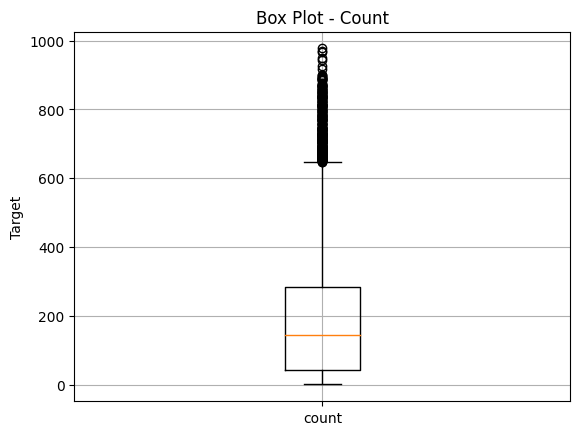

In [50]:
plt.boxplot([df['count']], labels=['count'])
plt.title('Box Plot - Count')
plt.ylabel('Target')
plt.grid(True)

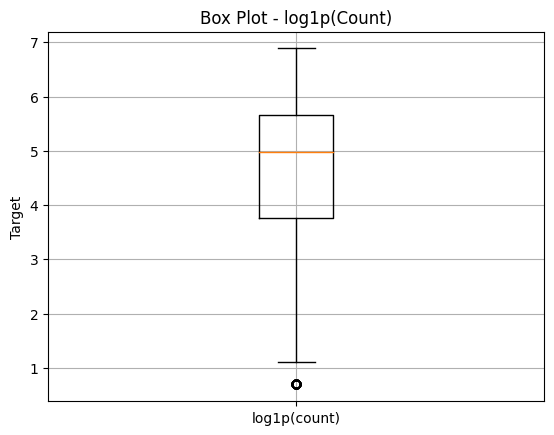

In [51]:
# Let's see how the data distribution changes with log1p
# Evenly distributed
plt.boxplot([df['count'].map(np.log1p)], labels=['log1p(count)'])
plt.title('Box Plot - log1p(Count)')
plt.ylabel('Target')
plt.grid(True)

In [52]:
df["count"] = df["count"].map(np.log1p)

In [56]:
df.to_csv('data/bike_all_log1p.csv',index=True,index_label='datetime',columns=columns)

In [57]:
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.loc[l]

In [58]:
rows = df.shape[0]
train = int(.7 * rows)
test = rows-train

In [ ]:

df.iloc[:train].to_csv('data/bike_train_log1p.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [62]:

df.iloc[train:].to_csv('data/bike_validation_log1p.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [61]:
df_test.to_csv('data/bike_test_log1p.csv',index=True,index_label='datetime')

In [66]:
column_list_file = 'data/bike_train_column_list.txt'
train_file = 'data/bike_train_log1p.csv'
validation_file = 'data/bike_validation_log1p.csv'
test_file = 'data/bike_test_log1p.csv'

In [64]:
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [67]:
df_train = pd.read_csv(train_file,names=columns)
df_validation = pd.read_csv(validation_file,names=columns)

In [68]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0].ravel()

In [69]:
regressor = xgb.XGBRegressor(max_depth=5,n_estimators=150)

In [70]:
regressor.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_validation, y_validation)])

[0]	validation_0-rmse:1.07449	validation_1-rmse:1.08536
[1]	validation_0-rmse:0.85458	validation_1-rmse:0.86613
[2]	validation_0-rmse:0.70927	validation_1-rmse:0.71996
[3]	validation_0-rmse:0.59990	validation_1-rmse:0.61145
[4]	validation_0-rmse:0.53030	validation_1-rmse:0.54376
[5]	validation_0-rmse:0.48986	validation_1-rmse:0.50343
[6]	validation_0-rmse:0.44070	validation_1-rmse:0.45739
[7]	validation_0-rmse:0.40047	validation_1-rmse:0.41874
[8]	validation_0-rmse:0.38562	validation_1-rmse:0.40625
[9]	validation_0-rmse:0.36942	validation_1-rmse:0.39214
[10]	validation_0-rmse:0.36043	validation_1-rmse:0.38604
[11]	validation_0-rmse:0.35108	validation_1-rmse:0.37771
[12]	validation_0-rmse:0.34115	validation_1-rmse:0.36872
[13]	validation_0-rmse:0.33376	validation_1-rmse:0.36312
[14]	validation_0-rmse:0.33041	validation_1-rmse:0.36143
[15]	validation_0-rmse:0.32675	validation_1-rmse:0.35916
[16]	validation_0-rmse:0.31363	validation_1-rmse:0.34789
[17]	validation_0-rmse:0.29994	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [71]:
eval_result = regressor.evals_result()

In [72]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

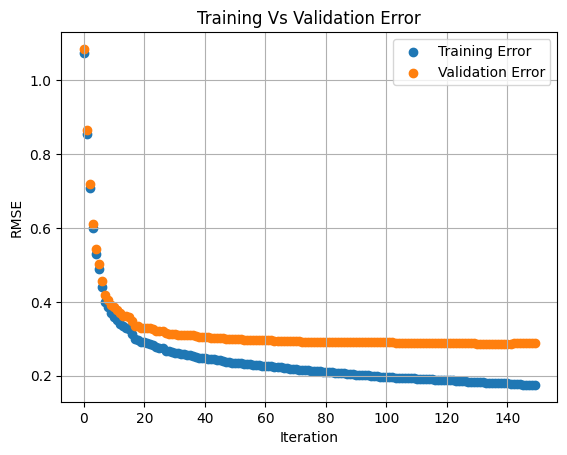

In [73]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

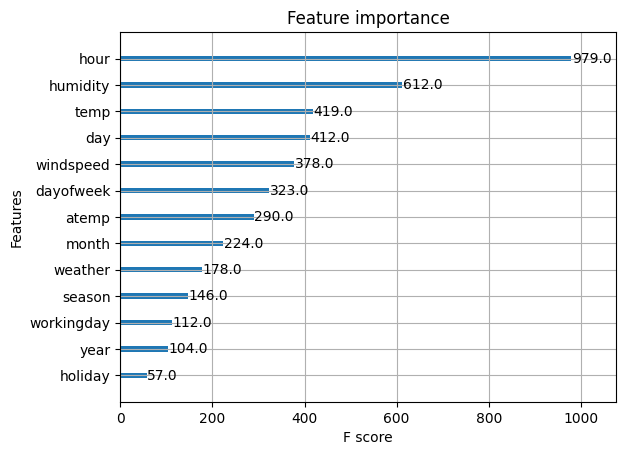

In [74]:
xgb.plot_importance(regressor)
plt.show()

In [75]:
df = pd.read_csv(validation_file, names=columns)

In [76]:
X_test = df.iloc[:,1:]

In [77]:
result = regressor.predict(X_test)

In [78]:
df['count_predicted'] = result

In [79]:
def adjust_count(x):
    if x < 0:
        return 0
    else:
        return x

In [80]:
df['count_predicted'] = df['count_predicted'].map(adjust_count)

In [81]:
df['count'] = df['count'].map(np.expm1)
df['count_predicted'] = df['count_predicted'].map(np.expm1)

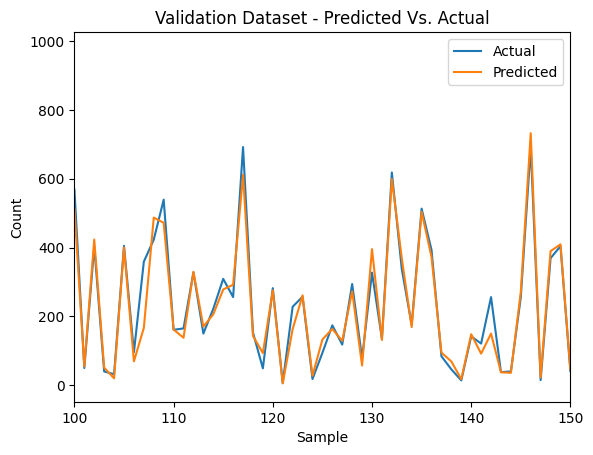

In [82]:
plt.plot(df['count'], label='Actual')
plt.plot(df['count_predicted'],label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.xlim([100,150])
plt.title('Validation Dataset - Predicted Vs. Actual')
plt.legend()
plt.show()

In [84]:
residuals = (df['count'] - df['count_predicted'])
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.52
 Over  Estimation: 0.48


In [86]:

print("RMSE: {0:.2f}".format(metrics.mean_squared_error(df['count'],
                                                    df['count_predicted'])**.5))

RMSE: 39.96


In [87]:
df_test = pd.read_csv(test_file,parse_dates=['datetime'])

In [88]:
X_test =  df_test.iloc[:,1:] # Exclude datetime for prediction

In [89]:
result = regressor.predict(X_test)

In [90]:
df_test["count"] = np.expm1(result)

In [91]:
df_test[['datetime','count']].to_csv('predicted_count_log1p_v2.csv',index=False)